# Comparing Ground Truth with Gridded Products

## 2. Satellite reflectance

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, datetime, timedelta
import requests
import os
import joblib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.plotting.register_matplotlib_converters()

In [2]:
import yaml
with open('../yaml/config2.yml') as config_data:
    c = yaml.load(config_data, Loader=yaml.SafeLoader)

from lib.parcel_utilities import *
clu_key = c['ag_analytics']['CLU']['KEY1']

# Set Descartes Labs credentials as environment variables
os.environ['DESCARTESLABS_CLIENT_ID'] = c['descartes']['DESCARTESLABS_CLIENT_ID']
os.environ['DESCARTESLABS_CLIENT_SECRET'] = c['descartes']['DESCARTESLABS_CLIENT_SECRET']

from lib.geospatial import *

In [3]:
# Some attributes of this site
lat, long, start, end = (41.17932065372352, -96.44152082846212, '2018-05-09', '2018-10-15')

In [4]:
from lib.parcel_utilities import *
clu_key = c['ag_analytics']['CLU']['KEY1']

from lib.geospatial import *

In [8]:
# Fetch DL Grids

# 1. Make an area of interest
# aoi = aoi_from_latlon(lat, long)
clu = clu_from_latlong(lat, long, clu_key, f='geojson')
aoi = aoi_from_clu(clu)

# 2. Search for the images that have that AOI
platform = S2 
metadata_client = dl.Metadata()
fc = metadata_client.search(
    products=platform,
    geom=aoi,
    start_datetime=start,
    end_datetime=end,
    limit=500,
)

# 3. Isolate the image IDs we're pulling data from
feat_ids = [feat["id"] for feat in fc["features"]]
print('Number of scenes: {}'.format(len(feat_ids)))

bands, scales = get_bands_from_platform(platform)

# 4. Gather the images into a stack and store
# raster_client = dl.Raster()
# images = list()
# for i, feat in enumerate(fc["features"]):
#     if i%25 == 0:
#         print(i)
#     feat_id = feat["id"]
#     arr, meta = raster_client.ndarray(
#         feat_id,
#         cutline=aoi,
#         bands=bands, 
#         scales=scales,
#         data_type="Float32",
#     )
#     images.append(arr)

# joblib.dump(images, 'dat/UNLCSP-2_{}.pkl'.format(platform))

Number of scenes: 124


In [9]:
# OR

# 5. Retrieve a previously analyzed image stack
images = joblib.load('dat/UNLCSP-2_{}.pkl'.format(platform))
feat_id = fc["features"][0]['id']

raster_client = dl.Raster()
arr, meta = raster_client.ndarray(
    feat_id,
    cutline=aoi,
    bands=bands, 
    scales=scales,
    data_type="Float32",
)

In [10]:
# 6. Extract Timeseries from Stack
dims = dims_from_images(images)
px = pixel_from_latlong(meta, dims, lat, long)
sdf = images_to_timeseries(fc, images, platform, dims, px)

sdf['date'] = sdf['UTC'].dt.date
sdf['date'] = pd.to_datetime(sdf['date'], utc=True)
sdf.drop_duplicates(subset=['date'],inplace=True)

# 7. Read device data and merge everything

# Read Device Data
df = pd.read_csv('dat/UNLCSP-3_daily.csv')
df['UTC'] = pd.to_datetime(df['UTC'], utc=True)

# Make a Backbone
df2 = pd.DataFrame()
df2['date'] = pd.date_range(start=start, end=end, freq="D", tz="UTC")

# Merge it all together
df2 = df2.merge(df, left_index=False, right_index=False, left_on='date',right_on='UTC', how='left')
df2 = df2.merge(sdf, left_on='date',right_on='date', how='left')

# Compare Different Data Sources

In [11]:
from lib.biology import *
df2['GDD'] = GDD(df2, Tlo=10., Thi=44., method='II', Tmincol='Tmin', Tmaxcol='Tmax')
df2['GDD'] = np.cumsum(df2['GDD'])

Text(0.5, 0, 'Degree Days')

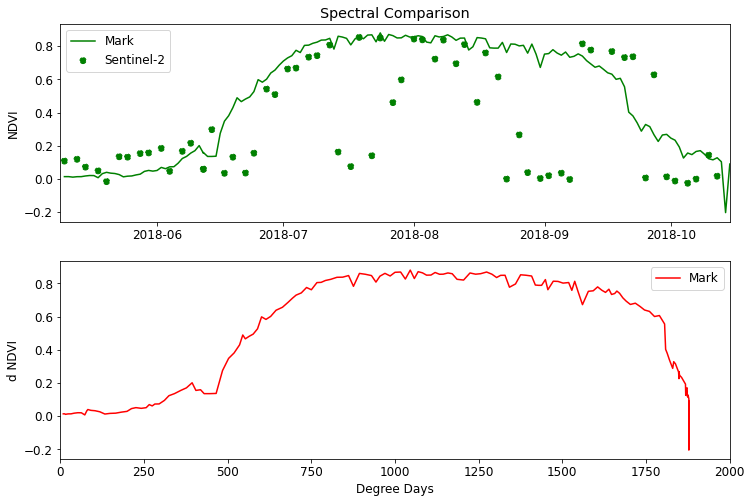

In [12]:
# NDVI Compare
xlim = [pd.to_datetime(start), pd.to_datetime(end)]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

# Date versus NDVI
line1 = axes[0].plot(df2.date, df2.NDVI, c='g', label = 'Mark')
line1 = axes[0].scatter(df2.date, df2.ndvi, c='g', ls='--', label = 'Sentinel-2')

ylim = axes[0].get_ylim()    

axes[0].set_xlim(xlim)    
axes[0].set_ylim(ylim)    
axes[0].legend()
axes[0].set_ylabel('NDVI')
axes[0].set_title('Spectral Comparison')

# GDD versus NDVI
line1, = axes[1].plot(df2.GDD, df2.NDVI, c='r', label = 'Mark')
line1 = axes[0].scatter(df2.GDD, df2.ndvi, c='g', ls='--', label = 'TWC')

ylim = axes[1].get_ylim()    

axes[1].set_xlim([0, 2000])    
axes[1].set_ylim(ylim)    
axes[1].legend()
axes[1].set_ylabel('d NDVI')
axes[1].set_xlabel('Degree Days')

# Exercises

4. Open the file dat/CSP-3_2018.csv.  What is the relationship between NDVI and AGBiomass? How about GreenLAI?  How about Height? In fact, which of these relationships has the highest correlation coefficient?

    This code may come in useful:
    ```python
obs = pd.read_csv('dat/CSP-3_2018.csv')
obs['date'] = pd.to_datetime('2018-01-01') + obs['doy'].map(timedelta)
    ```
    
    
5. Some authors have found the relationship between NDVI and fractional light absorption (fPAR) has this relationship:

    `fPAR = 1 - ((ndvi_max - NDVI)/(ndvi_max - ndvi_min))**0.625`
    
    and the relationship between fPAR and leaf area (LAI) has this relationship:

    `LAI = ln(1. - fPAR)/(-0.5)`

Are these good approximations for this dataset?
  
6. Assuming that half of downwelling shortwave (SWdw) falls as visible light (PAR), and that the light use efficiency of a crop is generally between 0 - 1 gC/MJ PAR, what is an estimate of the total absorbed light (APAR) for this crop?  How does that compare to the observed biomass?  If you wish, you can assume aboveground biomass is 80% of the total biomass.  

7. Identify when reproductive growth begins.  Create a heuristic, that is a metric derived from the NDVI curve such as its maximum or its maximumn rate of change, that corresponds to this important phenological moment.  